# Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
from IPython.display import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
warnings.filterwarnings("ignore")

# 17.1 생성적 적대 신경망 소개

GAN(Generative Adversarial Network)

주요한 목적은 훈련 데이터셋과 동일한 분포를 가진 새로운 데이터를 합성하는 것이다.

GAN의 원본 형태는 레이블 데이터가 필요하지 않으므로 비지도 학습 범주로 간주된다.

하지만 GAN을 확장한 것은 비지도 학습과 지도 학습 양쪽으로 모두 볼 수 있다.

이안 굿펠로우와 동료들이 심층 신경망을 사용하영 새로운 이미지를 합성하는 방법으로 2015년 처음 발표했다.

이 논문에서 제안한 초기 GAN 구조는 다층 퍼셉트론과 완전 연결 층을 기반으로 하여 낮은 해상도의 MNIST 손글씨 숫자를 생성하도록 훈련했다.

이후에 많은 애플리케이션이 만들어졌다.

이미지 투 이미지 변환 (입력 이미지에서 출력 이미지로 매팽하는 방법 학습)

이미지 초해상도 (낮은 해상도의 이미지를 높은 해상도의 이미지로 변환)

이미지 인페이팅 (이미지에서 누락된 부분을 재구성하는 방법을 학습)

## 17.1.1 오토인코더

훈련 데이터를 압축하고 해제할 수 있는 오토인코더.

오토인코더는 인코더 신경망과 디코더 신경망 두 개가 연결되어 구성된다.

인코더 신경망은 샘플 x에 연관된 d차원의 입력 특성 벡터를 받아 p차원의 벡터 z로 인코등한다.

인코딩된 벡터 z를 잠재 벡터라고 부른다.

일반적으로 p<d이다.

따라서 인코더가 데이터 압축 기능을 한다고 말할 수 있다.

디코더는 저차원 잠재 벡터 z에서 x_hat을 압축 해제합니다.

다음 그림은 인코더와 디코더가 각각 하나의 완전 연결 층으로 구성된다.

In [3]:
Image(url='https://git.io/JLAQ2', width=500)

위 예시는 은닉층이 없지만 비선형성을 가진 여러 은닉층을 추가하여 심층 오토인코더를 만들 수 있다.

이렇게 하면 더욱 효과적인 데이터 압축과 재구성 함수를 학습할 수 있다.

## 17.1.2 새로운 데이터 합성을 위한 생성 모델

오토인코더는 결정적인 모델이다.

오토인코더가 훈련되고 나면 입력 x에 대해 저차원 공간의 압축된 버전에서 이 입력을 재구성할 수 있다.

압축된 표현을 변환하는 식으로 입력을 재구성하는 것을 넘어서 새로운 데이터를 생성할 수 없다.

생설 모델은 랜덤한 벡터 z에서 새로운 샘플을 생성할 수 있다.

z는 완벽하게 특징을 알고 있는 간단한 분포에서 만들어지기에 쉽게 샘플링할 수 있다.

In [4]:
Image(url='https://git.io/JLAQH', width=700)

오토인코더의 디코더가 생성 모델과 비슷하다.

둘 다 잠재 벡터 z를 입력으로 받고 x와 동일한 공간에 있는 출력을 만든다.

차이점은 오토인코더에 있는 z의 분포는 알지 못하지만 생성 모델에서는 z의 분포를 완벽하게 알고 있다는 것이다.

오토인코더를 생성 모델로 일반화할 수 있고 VAE가 그중 한 가지 방법이다.

VAE에서는 입력 샘플을 받으면 인코더 신경망이 잠배 벡터 분포의 두 요소 평균과 분산을 계산한다.

VAE를 훈련하는 동안 평균과 분산을 표준 정규 분포에 맞추도록 신경망을 조정한다.

VAE 모델을 훈련한 후 인코더는 떼어내고 디코더 신경망을 사용하여 가우시안 분포에서 랜덤하게 샘플링한 z 벡터를 주입해서 새로운 샘플을 생성한다.

VAE 외에도 자기회귀 모델과 노멀라이징 플로 모델과 같은 다른 종류의 생성 모델이 많다.

----

생성 모델은 전통적으로 데이터 입력 분포 또는 입력 데이터와 연관된 타깃의 결합 분포를 모델링하는 알고리즘으로 정의한다.

정의에 따라 이 모델은 다른 특성을 조건으로 어떤 특성을 샘플링할 수 있다.

이를 조건부 추론이라고 한다. 

하지만 딥러닝에서 생성 모델이라고 하면 진짜처럼보이는 데이터를 생성하는 모델을 말한다.

## 17.1.3 GAN으로 새로운 샘플 생성

GAN이 하는 일의 핵심을 이해하기 위해선 알려진 분포에서 샘플링한 랜덤 벡터 z를 입력받아 출력 이미지 x를 생성하는 신경망을 생각해 보자.

이 신경망을 생성자라고 한다.

신경망을 랜덤한 가중치로 초기화한다.

가중치가 학습되기 전에 출력한 이미지는 백색 소음과 비슷할 것이다.

이미지의 품질을 평가흐는 함수로부터 피드백을 받아 생성된 이미지의 품질을 높이기 위해 가중치를 수정하도록 생성자 신경망에게 알려줄 수 있다.

그리고 이런 식으로 평가 함수의 피드백을 기반으로 생성자를 훈련시킬 수 있다.

생성자는 출력을 개선하여 진짜 이미지처럼 보이도록 학습될 것이다.

언급한 평가 함수가 이미지 생성 작업을 매우 쉽게 만들 수 있지만 이미지 품질을 평가하는 범용적인 함수가 있는지 있다면 어떻게 정의할 수 있는지가 관건이다.

사람은 신경망의 출력을 보고 쉽게 이미지 품질을 평가할 수 있다.

하지만 뇌에서 만든 결과를 아직 신경망으로 역전파할 수 없다.

이미지의 품질을 평가하는 신경망 모델은 판별자라고 불리는 신경망이다.

판별자는 진짜 이미지에서 합성 이미지를 감지하는 법을 학습하는 분류기이다.

In [5]:
Image(url='https://git.io/JLAQ7', width=700)

GAN에서 생성자와 판별자 두 신경망이 함께 훈련된다.

먼저 모델 가중치를 초기화한 후 생성자가 진짜처럼 보이지 않는 이미지를 만든다.

비슷하게 판별자는 초기에는 진짜 이미지와 가짜 이미지를 구분하는 능력은 형편없다.

하지만 시간이 지날수록 두 신경망이 상호 작용을 하면서 향상된다.

두 신경망이 적대적인 게임(adversarial game)을 수행한다.

생성자는 판별자를 속이기 위해 출력을 향상시키도록 학습된다.

판별자는 합성 이미지를 더 잘 감지하도록 훈련된다.

## 17.1.4 GAN의 생성자와 판별자 손실 함수 이해

In [6]:
Image(url='https://git.io/JLAQF', width=800)

GAN 모델은 두 개의 최적화 단계가 필요하다.

판별자에 대한 보상을 최대화하고 생성자에 대한 보상을 최소화한다.

실용적인 훈련 방법은 두 최적화 단계를 교대로 수행하는 것이다.

한 신경망의 가중치를 고정하고 다른 신경망의 가중치를 최소화한다.

두 번째 신경망을 고정하고 첫 번째 신경망을 최적화한다.

훈련 반복마다 이 과정을 반복한다.

GAN을 훈련할 때 사용할 수 있는 데이터 레이블은 판별자가 이진 분류기이면 이진 크로스 엔트로피 손실 함수를 사용할 수 있다.

# 17.2 밑바닥부터 GAN 모델 구현

## 17.2.1 구글 코랩에서 GAN 모델 구현

In [7]:
import tensorflow as tf
print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'cpu:0'
    
print(device_name)

2.7.0
GPU 여부: True
/device:GPU:0


## 17.2.2 생성자와 판별자 신경망 구현

원본 GAN 버전이며 바닐라 GAN이라고 부른다.

이 모델의 각 은닉층에는 LeakyReLU 활성화 함수를 사용하겠다.

렐루를 사용하면 희소한 그레이디언트가 발생하기에 입력 값 전 범위에 걸쳐 그레이디언트가 필요할 때는 적합하지 않기 때문이다.

각 은닉층 다음에는 드롭아웃 층이 뒤따른다.

출력층은 tanh 활성화 함수를 사용한다.

판별자의 출력층은 로짓을 계산하기 위해 활성화 함수를 가지지 않는다.

아니면 시그모이드 활성화 함수를 사용할 수 있다.

In [8]:
Image(url='https://git.io/JLAQp', width=600)

In [9]:
## 생성자 함수를 정의합니다:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

In [10]:
## 판별자 함수를 정의합니다:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model

In [11]:
image_size=(28,28)
z_size=20 #입력벡터 크기
mode_z='uniform'
gen_hidden_layers=1
gen_hidden_size=100
disc_hidden_layers=1
disc_hidden_size=100
tf.random.set_seed(1)


gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [12]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


## 17.2.3. 훈련 데이터셋 정의

mnist 데이터셋을 로드하고 필요한 전처리 단계를 적용한다.

생성자의 출력층이 tanh 활성화 함수를 사용하기에 합성된 이미지가 갖는 픽셀 값의 범위는 (-1,1)이다.

하지만 MNIST 이미지의 픽셀 범위는 [0,255]이다.

입력 이미지 텐서의 dtype을 uint8dptj float32로 바꾸겠다.

이 외에도 픽셀 강도의 범위를 [0,1]로 바꾼다.

여기에 2를 곱하고 1을 빼서 픽셀 강도를 [-1,1]로 조정하겠다.

또한, 랜덤한 분포를 기반으로 랜덤 벡터 z를 만든다.

그다음 전처리된 이미지와 랜덤 벡터를 튜플로 반환한다.

In [13]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [14]:
mnist_trainset = mnist['train']

print('전처리 전:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('전처리 후:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

전처리 전:  
dtype:  <dtype: 'uint8'>  최소: 0 최대: 255
전처리 후:  
dtype:  <dtype: 'float32'>  최소: -0.8737728595733643 최대: 0.9460210800170898


In [15]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_logits_real.shape)
print('판별자 (가짜) -- 크기:', d_logits_fake.shape)

input-z -- 크기: (32, 20)
input-real -- 크기: (32, 784)
생성자 출력 -- 크기: (32, 784)
판별자 (진짜) -- 크기: (32, 1)
판별자 (가짜) -- 크기: (32, 1)


## 17.2.4 GAN 모델 훈련하기

In [16]:
loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)

##생성자 손실
g_labels_real=tf.ones_like(d_logits_fake)
g_loss=loss_fn(y_true=g_labels_real,y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

생성자 손실: 0.7355


In [17]:
## 판별자 손실
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} 가짜 {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

판별자 손실: 진짜 1.5073 가짜 0.6583


In [18]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 준비
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## 손실 함수와 옵티마이저:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## 생성자 손실을 계산합니다
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        # g_loss의 그래디언트를 계산합니다
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        
        # 최적화: 그래디언트를 적용합니다
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## 판별자 손실을 계산합니다
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## d_loss의 그래디언트를 계산합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## 최적화: 그래디언트를 적용합니다
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        '에포크 {:03d} | 시간 {:.2f} min | 평균 손실 >>'
        ' 생성자/판별자 {:.4f}/{:.4f} [판별자-진짜: {:.4f} 판별자-가짜: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 0.72 min | 평균 손실 >> 생성자/판별자 2.8694/0.2889 [판별자-진짜: 0.0333 판별자-가짜: 0.2556]
에포크 002 | 시간 1.36 min | 평균 손실 >> 생성자/판별자 5.0631/0.3537 [판별자-진짜: 0.1178 판별자-가짜: 0.2359]
에포크 003 | 시간 2.00 min | 평균 손실 >> 생성자/판별자 3.2144/0.6981 [판별자-진짜: 0.3188 판별자-가짜: 0.3792]
에포크 004 | 시간 2.64 min | 평균 손실 >> 생성자/판별자 2.1307/0.8393 [판별자-진짜: 0.4388 판별자-가짜: 0.4005]
에포크 005 | 시간 3.28 min | 평균 손실 >> 생성자/판별자 2.2013/0.8035 [판별자-진짜: 0.4315 판별자-가짜: 0.3720]
에포크 006 | 시간 3.93 min | 평균 손실 >> 생성자/판별자 1.7302/0.9205 [판별자-진짜: 0.5032 판별자-가짜: 0.4173]
에포크 007 | 시간 4.57 min | 평균 손실 >> 생성자/판별자 1.6118/0.9338 [판별자-진짜: 0.5222 판별자-가짜: 0.4116]
에포크 008 | 시간 5.21 min | 평균 손실 >> 생성자/판별자 1.5811/1.0142 [판별자-진짜: 0.5361 판별자-가짜: 0.4782]
에포크 009 | 시간 5.85 min | 평균 손실 >> 생성자/판별자 1.4343/0.9936 [판별자-진짜: 0.5477 판별자-가짜: 0.4459]
에포크 010 | 시간 6.48 min | 평균 손실 >> 생성자/판별자 1.3902/1.0532 [판별자-진짜: 0.5638 판별자-가짜: 0.4894]
에포크 011 | 시간 7.12 min | 평균 손실 >> 생성자/판별자 1.3796/1.0679 [판별자-진짜: 0.5650 판별자-가짜: 0.5030]
에포크 012 | 시간 7.77 min | 평균 손실 >> 생성자/판별자 1.

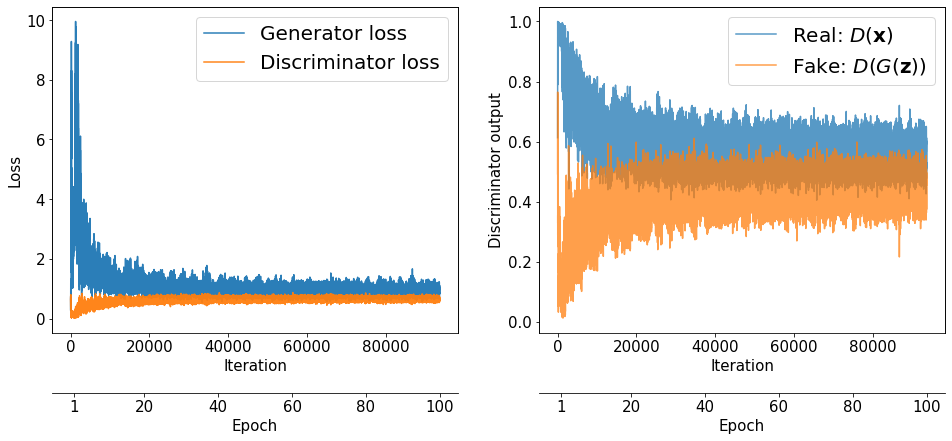

In [19]:
import itertools


fig = plt.figure(figsize=(16, 6))

## 손실 그래프
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## 판별자의 출력
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

초기에는 판별자가 가짜와 진짜 샘플을 매우 정확하게 구별하는 법을 빠르게 배운다.

즉, 가짜 샘플의 확률이 0에 가깝다.

훈련이 진행되면서 생성자가 더 진짜 같은 미지를 합성하게 되면 진짜와 가짜 샘플에 대한 확률이 모두 0.5에 가까워진다.

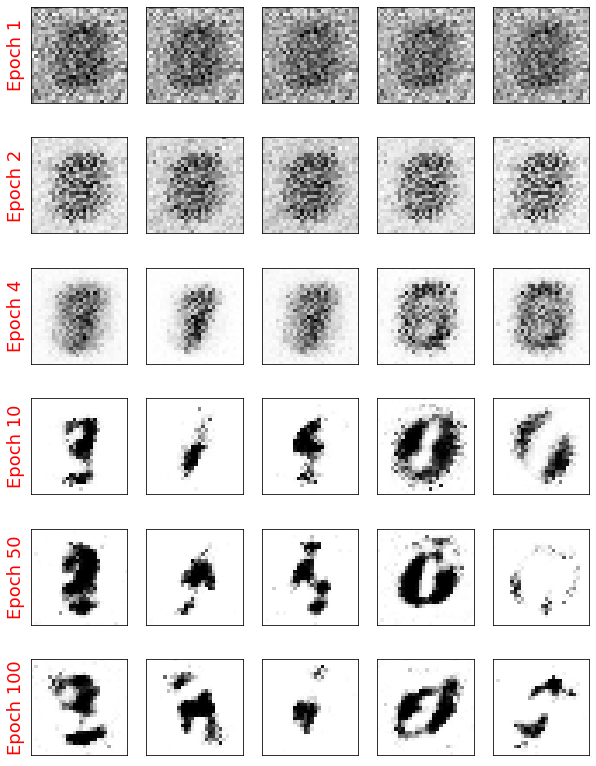

In [20]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

합성곱 층을 사용한 신경망은 완전 연결 층보다 장점이 있듯이 GAN 모델에 합성곱 층을 추가하면 더 나은 결과를 얻을 수 있다.